# What has Happened to my Patient since I last saw them?

Workflow:  
- Get the notes from central repository
- Store in dictionary
- Find date of last note by Dr. ______
- Sort Notes
- Summarize Notes which occurred after the date of last note by Dr. ______





In [1]:
import random
import datetime

import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import os
import re
import csv
import ast 
import openai
import webbrowser
import json
from json import loads, dumps
from docx import Document


import subprocess

import logging #https://www.machinelearningplus.com/python/python-logging-guide/


from chatGPT_utilities import setup_OpenAI_API
from chatGPT_utilities import json_to_dict
from chatGPT_utilities import pp_json
from chatGPT_utilities import get_completion
from chatGPT_utilities import get_completion_from_messages_FULL
from chatGPT_utilities import get_completion_from_messages_FULL_and_costs
from chatGPT_utilities import get_completion_from_messages
from chatGPT_utilities import read_file
from chatGPT_utilities import token_usage
from chatGPT_utilities import print_token_usage
from chatGPT_utilities import openai_object_to_dict
from chatGPT_utilities import read_patient_notes

from what_happened_utils import create_doctor_date_dataframe
from what_happened_utils import generate_list_of_doctors_notes
from what_happened_utils import extract_clinical_data
from what_happened_utils import read_notes
from what_happened_utils import Display_Notes
from what_happened_utils import show_list_of_Doctors_for_pt
from what_happened_utils import scatter_plot_show_dates_notes
from what_happened_utils import find_notes_from_Doctor_X
from what_happened_utils import concatenate_Notes_EXCEPT_Doctor_X
from what_happened_utils import Sort_notes_by_date_concatenated

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

openai.api_key = setup_OpenAI_API()

# Globals

In [2]:
starting_directory = os.getcwd()
random.seed(42)  # Set the random seed for reproducibility
color_map = {
    "Doctor_1": "Red",
    "Doctor_2": "Blue",
    "Doctor_3": "Green",
    "Doctor_4": "Black",
    "Doctor_5": "Orange",
    "Doctor_6": "Purple",
    "Doctor_7": "Pink",
    "Doctor_8": "Cyan",
    "Doctor_9": "Magenta",
    "Doctor_10": "Lime"
}
random.seed(42) # used when generating synthetic data

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    datefmt='%a, %d  %b %Y %H:%M:%S')

logging.getLogger().setLevel(logging.DEBUG)
logging.debug('Global variables initialized')

Mon, 17  Jul 2023 15:36:22 DEBUG    Global variables initialized


# Read a Single Patient's Clinic Visits


In [3]:
assert os.getcwd() == starting_directory , 'We should be in starting directory'
pt_notes_dir, patient_name = 'John_Smith_Notes',  'John_Smith'
pt_notes_dir, patient_name = 'Jose_Alvarez_Notes', 'Jose_Alvarez'
print(f'\nCollecting the clinic notes of {patient_name}\n\n')
dict_of_notes =read_notes(pt_notes_dir,patient_name)
logging.debug(f'Reading {patient_name} ')
list_of_Doctors = show_list_of_Doctors_for_pt(dict_of_notes,patient_name)

Mon, 17  Jul 2023 15:36:22 DEBUG    Reading Jose_Alvarez 





Reading the following files from "Jose Alvarez Notes" :


Reading Jose_Alvarez_2023_06_30.txt  Dr. Doctor_3                        Jun 30, 2023 Initial 
Reading Jose_Alvarez_2023_02_02.txt  Dr. Doctor_5                        Feb 02, 2023 Initial 
Reading Jose_Alvarez_2023_01_30.txt  Dr. Doctor_5                        Jan 01, 2023 Return 
Reading Jose_Alvarez_2023-07-11.txt  Dr. Doctor_1                        Jul 11, 2023 Initial 
Reading Jose_Alvarez_2023_03_30.txt  Dr. Doctor_3                        Mar 30, 2023 Return 


Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5


# Display Notes

In [4]:
Display_Notes(dict_of_notes,patient_name)



Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5
Doctor_1
Number of notes by Dr. Doctor_1 : 1 


1. Dr. Doctor_1 saw Jose_Alvarez on 2023-07-11
Note:
Name: Jose Alvarez
Doctor : Doctor_1
Age: 62
Gender: Male
Date of Visit: Jul 11, 2023

Chief Complaint:
Mr. Alvarez presents for annual physical examination

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD), which was diagnosed 10 years ago. He has a significant smoking history of 40 pack-years. Mr. Alvarez reports a progressive increase in dyspnea over the past week, with minimal exertion. He also complains of a productive cough with yellowish sputum. He denies any recent fever, chest pain, or hemoptysis. Mr. Alvarez states that his symptoms have interfered with his daily activities and quality of life.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbati

## Dates of Doctors' Notes

In [5]:
# show_dates_doctors_notes()

In [6]:
list_of_Doctors = show_list_of_Doctors_for_pt(dict_of_notes,
                               patient_name)
df_doctors_notes = create_doctor_date_dataframe(dict_of_notes,
                                                list_of_Doctors)
index_values = list_of_Doctors
multi_index_df = df_doctors_notes.set_index(['Doctor', 'Date']).sort_values(by=['Doctor', 'Date'])
print(f'\n\n\033[91m\033[1m Listed by Doctor - Alphabetically\033[0m')
multi_index_df
print(f'\n\n\033[91m\033[1m Listed Chronologically\033[0m')
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop = True)
df_doctors_notes



Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5


 Listed by Doctor - Alphabetically


Empty DataFrame
Columns: []
Index: [(Doctor_1, 2023-07-11), (Doctor_3, 2023-03-30), (Doctor_3, 2023-06-30), (Doctor_5, 2023-01-01), (Doctor_5, 2023-02-02)]



 Listed Chronologically


,Doctor,Date
0,Doctor_5,2023-01-01
1,Doctor_5,2023-02-02
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


## Plot Visit Dates


Empty DataFrame
Columns: []
Index: [(Doctor_1, 2023-07-11), (Doctor_3, 2023-03-30), (Doctor_3, 2023-06-30), (Doctor_5, 2023-01-01), (Doctor_5, 2023-02-02)]

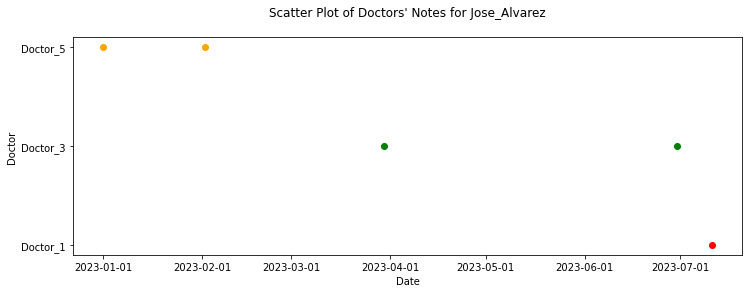

In [7]:
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map )
multi_index_df

### All Previous Notes in Chronological Order

In [8]:
print(f'{patient_name} Visits')
for i in df_doctors_notes.index:
    print(f'{i+1:5}. {df_doctors_notes.loc[i,"Doctor"]}   {df_doctors_notes.loc[i,"Date"]}')
print('\n'*2 ) 
for i in df_doctors_notes.index:
    name_of_doctor = df_doctors_notes.loc[i,"Doctor"]
    date = df_doctors_notes.loc[i,"Date"]
    list_of_notes_from_doctor = dict_of_notes[name_of_doctor]['Notes']
    for clinic_note in list_of_notes_from_doctor:
        if clinic_note['Date'] ==date:
            the_clinic_note = clinic_note['Content'].replace('Date of Visit',
                                         '\033[91m\033[1mDate of Visit\033[0m')
            print(f"{the_clinic_note.split('History of Present Illness')[0]}")
            print(f"\t\t\t----------------------------")
    # print('\n' ) 

Jose_Alvarez Visits
    1. Doctor_5   2023-01-01
    2. Doctor_5   2023-02-02
    3. Doctor_3   2023-03-30
    4. Doctor_3   2023-06-30
    5. Doctor_1   2023-07-11



Name: Jose Alvarez
Doctor : Doctor_5
Age: 62
Gender: Male
Date of Visit: Jan 1, 2023

Chief Complaint:
Mr. Alvarez presents with worsening shortness of breath and cough.


			----------------------------
Name: Jose Alvarez
Doctor : Doctor_5
Age: 62
Gender: Male
Date of Visit: Feb 2, 2023

Chief Complaint:
Mr. Alvarez is here for a follow up visit regarding his recent exacerbation.


			----------------------------
Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Mar 30, 2023

Chief Complaint:
Rosacea


			----------------------------
Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Jun 30, 2023

Chief Complaint:
follow up for rosacea


			----------------------------
Name: Jose Alvarez
Doctor : Doctor_1
Age: 62
Gender: Male
Date of Visit: Jul 11, 2023

Chief Complaint:
Mr. 


## Find Notes After Date
### Mark a Date on the Chart


- For a given patient, show the notes after a specific date

,Doctor,Date
0,Doctor_5,2023-01-01
1,Doctor_5,2023-02-02
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


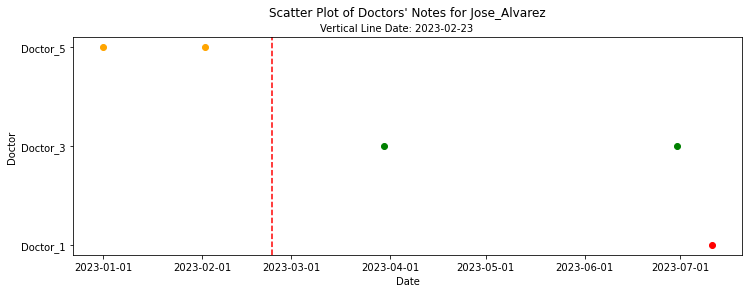

In [9]:
df_doctors_notes = df_doctors_notes.sort_values(['Date','Doctor'], ascending=[True,True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
df_doctors_notes
mark_this_date = "Feb 23 2023"
scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map,
                              mark_this_date)

### Assume you are Doctor 5, find previous notes


In [10]:
name_of_doctor = 'Doctor_5'
logging.getLogger().setLevel(logging.DEBUG)
logging.debug(f'Assume you are {name_of_doctor}, Finding previous notes')
sorted_list_of_notes_from_doctor, date_of_last_note =     \
    find_notes_from_Doctor_X(dict_of_notes,
                         name_of_doctor) 

Mon, 17  Jul 2023 15:36:23 DEBUG    Assume you are Doctor_5, Finding previous notes




Number of Notes 2
  1: 2023-01-01
  2: 2023-02-02
Last Note by Doctor_5:  2023-02-02



2023-01-01
		Name: Jose Alvarez
Doctor : Doctor_5
Age: 62
Gender: Male
Date of Visit: Jan 1, 2023

Chief Complaint:
Mr. Alvarez presents with worsening shortness of breath and cough.

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD), which was diagnosed 10 years ago. He has a significant smoking history of 40 pack-years. Mr. Smith reports a progressive increase in dyspnea over the past week, with minimal exertion. He also complains of a productive cough with yellowish sputum. He denies any recent fever, chest pain, or hemoptysis. Mr. Smith states that his symptoms have interfered with his daily activities and quality of life.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroi

 <div class="alert alert-block alert-success">
    Now we have last date, find all notes after that date

</div>


### Mark Last Note from Doctor 5

Last note from Doctor_5 was on : Feb 02 2023


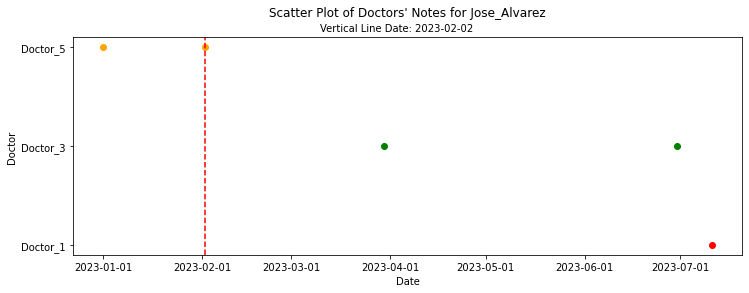

,Doctor,Date
0,Doctor_5,2023-01-01
1,Doctor_5,2023-02-02
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


Mon, 17  Jul 2023 15:36:23 DEBUG    Marked last note


In [11]:
logging.getLogger().setLevel(logging.ERROR)
# logging.getLogger().setLevel(logging.DEBUG)

date_line = date_of_last_note.strftime('%b %d %Y')
print(f'Last note from {name_of_doctor} was on : {date_line}')

scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map,
                              date_line)
# print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
df_doctors_notes
# logging.getLogger().setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug('Marked last note')

### Look for Notes after Doctor X's last note

In [12]:
mask = df_doctors_notes['Date'] > date_of_last_note
df_remaining_notes = df_doctors_notes[mask] 
df_remaining_notes  = df_remaining_notes.reset_index(drop =  True)
df_remaining_notes

,Doctor,Date
0,Doctor_3,2023-03-30
1,Doctor_3,2023-06-30
2,Doctor_1,2023-07-11


## Concatenate All Notes Except Doctor X

Various Options (depending on future needs):
- concatenate_Notes_EXCEPT_Doctor_X
- concatenate_notes_after_date
- **Sort_notes_by_date_concatenated** which is used here


 

### Sort Notes By Date
- Short version and concatenates content

Last note from Doctor_5 was on : Feb 02 2023


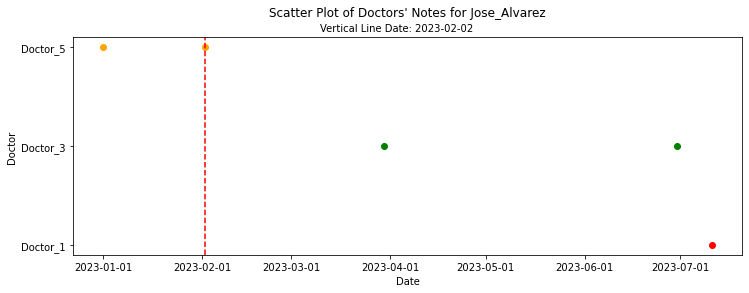

Notes Sorted Chronologically across all Doctors:
Concatenated Content across all Doctors after 2023-05-01:




		--------------------------------------------------------------------------

Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Mar 30, 2023

Chief Complaint:
Rosacea

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD)
He has experienced some recent facial flushing and has noticed some Small blood vessels on the side of his nose.


Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.

S

In [13]:
date_line = date_of_last_note.strftime('%b %d %Y')
print(f'Last note from {name_of_doctor} was on : {date_line}')

scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map,
                              date_line)

certain_date = datetime.date(2023, 5, 1)
concatenated_content = Sort_notes_by_date_concatenated(dict_of_notes,date_of_last_note)
concatenated_content = concatenated_content.replace('Name','\n\n\t\t--------------------------------------------------------------------------\n\nName')
print(f"Concatenated Content across all Doctors after {certain_date}:\n\n")
print(concatenated_content) 
notes_string = concatenated_content

# AT THIS POINT - We start with chatGPT API
 
We have determined the 
- **DATE OF THE LAST NOTE**   
- by the **DOCTOR IN QUESTION** and have the notes that follow that.

Note the line <span style="color:red">**I will start him on Doxycycline 50 mg bid for his rosacea** </span>.


In [14]:
notes_string = concatenated_content

In [15]:
new_notes_string = notes_string.replace('#####',"####")
print(new_notes_string.split('I will start him on Doxycycline 50 mg bid for his rosacea')[0])
print('\033[91m'+ '\033[1m' + 'I will start him on Doxycycline 50 mg bid for his rosacea' + '\033[0m')
\
 
print(new_notes_string.split('I will start him on Doxycycline 50 mg bid for his rosacea')[1])



		--------------------------------------------------------------------------

Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Mar 30, 2023

Chief Complaint:
Rosacea

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD)
He has experienced some recent facial flushing and has noticed some Small blood vessels on the side of his nose.


Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.

Social History:
Mr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD 

In [16]:

# url_chatGPT_usage = 'https://platform.openai.com/account/usage'
# webbrowser.open_new(url_chatGPT_usage)


## Prompt 0  
Show     
- Doctor:  
- Diagnosis:  
- Medications: List each medication on a separate line  



Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, 
delimited by triple quotes
extract the information relevant to the patient's condition. 

List the dates of visits in chronological order and
include a summary of the visit including the date,
which doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
    
    



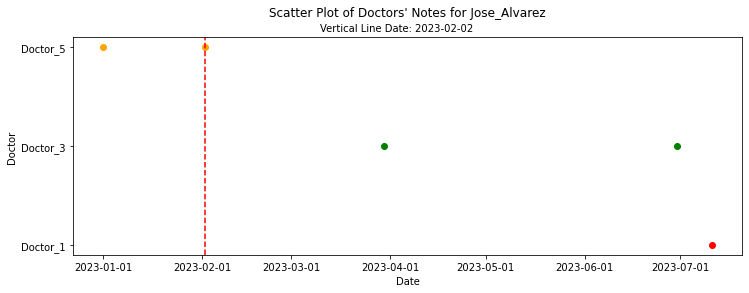

,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY
Visit # 1 - Mar 30, 2023
    Doctor: Doctor_3
    Diagnosis: Rosacea
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 2 - Jun 30, 2023
    Doctor: Doctor_3
    Diagnosis: Follow up for rosacea
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 3 - Jul 11, 2023
    Doctor: Doctor_1
    Diagnosis: Annual physical examination
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea 


Time to Execute Task
Start  : 15:36:24
End    : 15:36:32
Elapsed: 8.749 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:        228
Prompt tokens    :      1,222
Total tokens     :      1,450
Cost to run query: $0.003


In [17]:
delimiter = '####'
prompt_0 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \ndelimited by triple quotes\nextract the information relevant to the patient's condition. 

List the dates of visits in chronological order and\ninclude a summary of the visit including the date,\nwhich doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
    
    
Review: ```{new_notes_string}```

    """

prompt_string = prompt_0.split('Review')[0]
# print('\033[91m'+ '\033[1m' + prompt_string+ '\033[0m')
print('\033[255;0;0;1m' + prompt_string+ '\033[0m')


# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
vertical_line_date = date_of_last_note
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)



df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_0)
# logging.getLogger().setLevel(logging.DEBUG)
# logging.debug(f'scatter')


## Prompt 1 : One Additional Instruction
 <div class="alert alert-block alert-warning">
Be sure not to list any medications that the patient will be started on during a visit
</div>


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, 
delimited by triple quotes
extract the information relevant to the patient's condition. 

List the dates of visits in chronological order and
include a summary of the visit including the date,
which doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Be sure not to list any medications that the patient will be started on during a visit




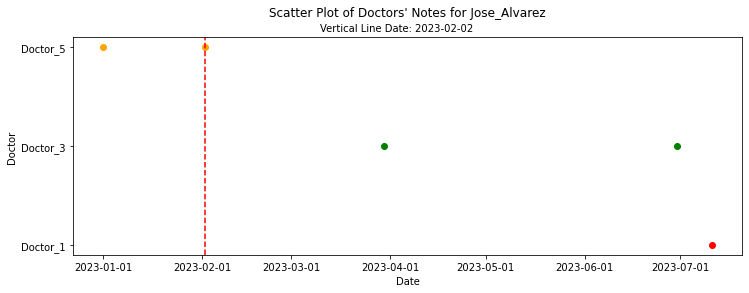

Index(['Doctor', 'Date'], dtype='object')


,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY


Mon, 17  Jul 2023 15:36:41 DEBUG    scatter


Visit # 1 - Mar 30, 2023
    Doctor: Doctor_3
    Diagnosis: Rosacea
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia

Visit # 2 - Jun 30, 2023
    Doctor: Doctor_3
    Diagnosis: Follow up for rosacea
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 3 - Jul 11, 2023
    Doctor: Doctor_1
    Diagnosis: Annual physical examination
    Medications:
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea 


Time to Execute Task
Start  : 15:36:32
End    : 15:36:41
Elapsed: 8.107 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:        213
Prompt tokens    :      1,249
Total tokens     :      1,462
Cost to run query: $0.003


In [18]:
delimiter = '####'
prompt_1 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \ndelimited by triple quotes\nextract the information relevant to the patient's condition. 

List the dates of visits in chronological order and\ninclude a summary of the visit including the date,\nwhich doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Be sure not to list any medications that the patient will be started on during a visit

Review: ```{new_notes_string}```

    """

string = 'Be sure not to list any medications that the patient will be started on during a visit'
red_bold_string = '\033[91m'+ '\033[1m' + string+ '\033[0m'
prompt_1 = prompt_1.replace(string,red_bold_string)
# print(prompt_1.split('Review')[0])

prompt_string = prompt_1.split('Review')[0]
print('\033[255;0;0;1m' + prompt_string+ '\033[0m')
vertical_line_date = date_of_last_note
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)

# scatter_plot_show_dates_notes(df_doctors_notes, vertical_line_date)
print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_1)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug(f'scatter')

## Prompt 2 : List Dates of Visits and with Whom 


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, delimited by triple quotes.

List
	dates of visits in chronological order and
	display which doctor saw the patient.
Do not list any additional information.




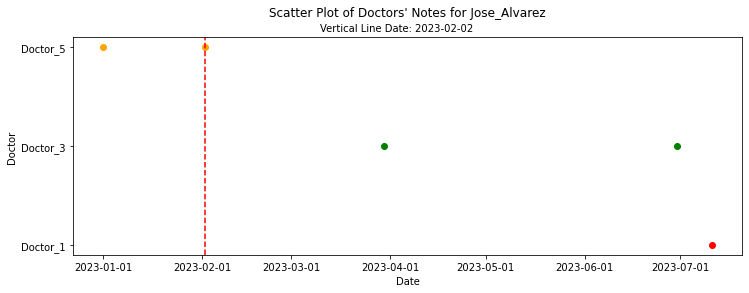

Index(['Doctor', 'Date'], dtype='object')


,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY
Dates of visits in chronological order and the doctor who saw the patient:

1. Mar 30, 2023 - Doctor_3
2. Jun 30, 2023 - Doctor_3
3. Jul 11, 2023 - Doctor_1 


Time to Execute Task
Start  : 15:36:41
End    : 15:36:44
Elapsed: 2.794 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:         55
Prompt tokens    :      1,119
Total tokens     :      1,174
Cost to run query: $0.002


In [19]:
delimiter = '####'
prompt_2 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \
delimited by triple quotes.

List\n\tdates of visits in chronological order and\n\tdisplay which doctor saw the patient.
Do not list any additional information.

Review: ```{new_notes_string}```

    """
# print(prompt_2.split('Review')[0])
prompt_string = prompt_2.split('Review')[0]
print('\033[255;0;0;1m' + prompt_string+ '\033[0m')

# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
# vertical_line_date = date_of_last_note
# print(vertical_line_date)
date_line = date_of_last_note.strftime('%b %d %Y')

logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)
print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_2)

## Prompt 3 : How many visits with each Doctor ?


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, delimited by triple quotes
extract the information relevant to the patient's condition. 


List the doctors who saw the patient and how many visits with each doctor.
Use the following format:
X visits with Doctor 
    Visit Date
    Visit Date

X visits with Doctor 
    Visit Date
    Visit Date
    




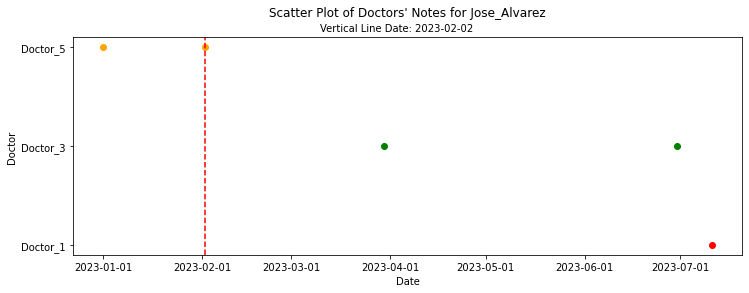

START QUERY
The relevant information extracted from the clinical notes is as follows:

Doctor_3:
- Visit Date: Mar 30, 2023
- Visit Date: Jun 30, 2023

Doctor_1:
- Visit Date: Jul 11, 2023

Summary:
2 visits with Doctor_3
1 visit with Doctor_1 


Time to Execute Task
Start  : 15:36:44
End    : 15:36:47
Elapsed: 3.326 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:         71
Prompt tokens    :      1,151
Total tokens     :      1,222
Cost to run query: $0.002


In [20]:
delimiter = '####'
start_query_delimiter  = '---'
prompt_3 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \
delimited by triple quotes\nextract the information relevant to the patient's condition. 


List the doctors who saw the patient and how many visits with each doctor.
Use the following format:
X visits with Doctor 
    Visit Date
    Visit Date

X visits with Doctor 
    Visit Date
    Visit Date
    

Review: ```{new_notes_string}```

    """
prompt_string = prompt_3.split('Review')[0]
print('\033[255;0;0;1m' + prompt_string+ '\033[0m')

# print(prompt_3.split(start_query_delimiter)[1].split('Review')[0])

# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
# vertical_line_date = date_of_last_note
# print(vertical_line_date)
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                            date_line)
# print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
response = get_completion_from_messages_FULL_and_costs(prompt_3)

In [21]:


logging.getLogger().setLevel(logging.DEBUG)

logging.debug(f'we are done!')




Mon, 17  Jul 2023 15:36:47 DEBUG    we are done!


# End of Use Cases

The names of the functions, along with their parameters, are as follows:

1. `extract_clinical_data(file_path)` - Parameters: `file_path`
2. `read_notes(Dir_Notes, patient_name)` - Parameters: `Dir_Notes`, `patient_name`
3. `Display_Notes(dict_of_notes, patient_name)` - Parameters: `dict_of_notes`, `patient_name`
4. `scatter_plot_show_dates_notes(df, patient_name, color_map, date_line=None)` - Parameters: `df`, `patient_name`, `color_map`, `date_line`
5. `show_list_of_Doctors_for_pt(dict_of_notes, patient_name)` - Parameters: `dict_of_notes`, `patient_name`
6. `create_doctor_date_dataframe(my_dict, doctors_list)` - Parameters: `my_dict`, `doctors_list`
7. `find_notes_from_Doctor_X(dict_of_notes, name_of_doctor)` - Parameters: `dict_of_notes`, `name_of_doctor`
8. `concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes, Doctor_X)` - Parameters: `dict_of_notes`, `Doctor_X`
9. `Sort_notes_by_date_concatenated(my_dict, certain_date)` - Parameters: `my_dict`, `certain_date`
10. `concatenate_notes_after_date(dict_of_notes, after_date)` - Parameters: `dict_of_notes`, `after_date`
11. `display_dict_by_doctor_date_note(dictionary)` - Parameters: `dictionary`
12. `random_dates_for_visits()` - No parameters
13. `find_notes_after_date(doctors_list, date)` - Parameters: `doctors_list`, `date`
14. `OLD____scatter_plot_show_dates_notes(df, vertical_line_date=None)` - Parameters: `df`, `vertical_line_date`
15. `OLD_concatenate_notes_after_date(data, after_date)` - Parameters: `data`, `after_date`
16. `OLD_find_notes_from_Doctor_X(dict_of_notes, name_of_doctor)` - Parameters: `dict_of_notes`, `name_of_doctor`

Please note that the names of some functions are prefixed with "OLD" to indicate that they are outdated or not used.

In [46]:
string = "1. extract_clinical_data(file_path) - Parameters: file_path\n" \
         "2. read_notes(Dir_Notes, patient_name) - Parameters: Dir_Notes, patient_name\n" \
         "3. Display_Notes(dict_of_notes, patient_name) - Parameters: dict_of_notes, patient_name\n" \
         "4. scatter_plot_show_dates_notes(df, patient_name, color_map, date_line=None) - Parameters: df, patient_name, color_map, date_line\n" \
         "5. show_list_of_Doctors_for_pt(dict_of_notes, patient_name) - Parameters: dict_of_notes, patient_name\n" \
         "6. create_doctor_date_dataframe(my_dict, doctors_list) - Parameters: my_dict, doctors_list\n" \
         "7. find_notes_from_Doctor_X(dict_of_notes, name_of_doctor) - Parameters: dict_of_notes, name_of_doctor\n" \
         "8. concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes, Doctor_X) - Parameters: dict_of_notes, Doctor_X\n" \
         "9. Sort_notes_by_date_concatenated(my_dict, certain_date) - Parameters: my_dict, certain_date\n" \
         "10. concatenate_notes_after_date(dict_of_notes, after_date) - Parameters: dict_of_notes, after_date\n" \
         "11. display_dict_by_doctor_date_note(dictionary) - Parameters: dictionary\n" \
         "12. random_dates_for_visits() - No parameters\n" \
         "13. find_notes_after_date(doctors_list, date) - Parameters: doctors_list, date\n" \
         "14. OLD____scatter_plot_show_dates_notes(df, vertical_line_date=None) - Parameters: df, vertical_line_date\n" \
         "15. OLD_concatenate_notes_after_date(data, after_date) - Parameters: data, after_date\n" \
         "16. OLD_find_notes_from_Doctor_X(dict_of_notes, name_of_doctor) - Parameters: dict_of_notes, name_of_doctor"

formatted_string = "\n".join([line.split('-')[0].strip() for line in string.split('\n')])


In [48]:
print(formatted_string)

1. extract_clinical_data(file_path)
2. read_notes(Dir_Notes, patient_name)
3. Display_Notes(dict_of_notes, patient_name)
4. scatter_plot_show_dates_notes(df, patient_name, color_map, date_line=None)
5. show_list_of_Doctors_for_pt(dict_of_notes, patient_name)
6. create_doctor_date_dataframe(my_dict, doctors_list)
7. find_notes_from_Doctor_X(dict_of_notes, name_of_doctor)
8. concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes, Doctor_X)
9. Sort_notes_by_date_concatenated(my_dict, certain_date)
10. concatenate_notes_after_date(dict_of_notes, after_date)
11. display_dict_by_doctor_date_note(dictionary)
12. random_dates_for_visits()
13. find_notes_after_date(doctors_list, date)
14. OLD____scatter_plot_show_dates_notes(df, vertical_line_date=None)
15. OLD_concatenate_notes_after_date(data, after_date)
16. OLD_find_notes_from_Doctor_X(dict_of_notes, name_of_doctor)


In [ ]:
# concatenate_Notes = concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes,'Doctor_5')
# print(concatenate_Notes)
# print(f'date_line : {date_line}')
# concatenate_Notes = concatenate_notes_after_date(dict_of_notes, datetime.datetime.strptime(date_line, "%b %d %Y").date())